## Prerequisite
### Download Six-sided Dice dataset
This is [a download link for Six-sided Dice dataset in Kaggle](https://www.kaggle.com/datasets/nellbyler/d6-dice?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `d6-dice` directory with annotations and images in YOLO format as follows.

```bash
d6-dice
├── Annotations
│   ├── classes.txt
│   ├── IMG_20191208_111228.txt
│   ├── IMG_20191208_111246.txt
│   ├── ...
└── Images
    ├── IMG_20191208_111228.jpg
    ├── IMG_20191208_111246.jpg
    ├── ...
```

However, for import compatibility, `obj.names` file must be added to `d6-dice/obj.names` filepath for import compatibility. This `obj.names` file includes the label names of the dataset, e.g., `[dice1, ..., dice6]`. Therefore, you can write it with the following simple code. Please see [Yolo Loose format](https://openvinotoolkit.github.io/datumaro/docs/formats/yolo/) for more details.

In [1]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import os

root_dir = "d6-dice"

names = """
dice1
dice2
dice3
dice4
dice5
dice6
"""

fpath = os.path.join(root_dir, "obj.names")
with open(fpath, "w") as fp:
    fp.write(names)

## Import dataset

Firstly, we import this dataset using Datumaro Python API. The Six-sided Dice dataset has no subset split so that Datumaro will create "default" subset for it.

In [2]:
from datumaro import Dataset

dataset = Dataset.import_from("./d6-dice", format="yolo")
dataset

Dataset
	size=250
	source_path=./d6-dice
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=250
	annotations_count=1795
subsets
	default: # of items=250, # of annotated items=250, # of annotations=1795, annotation types=['bbox']
infos
	categories
	label: ['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

## Export dataset with encryption

We will export the dataset to the `d6-dice-encryption` directory while turning on the `encryption=True` option to encrypt the dataset. After exporting, a `secret_key.txt` file will be created in the export directory. You must keep this key separate from the exported dataset and never lose it, as it is necessary for importing the dataset later on.

In [3]:
dataset.export(save_dir="d6-dice-encrypted", format="datumaro_binary", encryption=True, save_media=True)

print("Directory structure:", os.listdir("d6-dice-encrypted"))

with open("d6-dice-encrypted/secret_key.txt", "r") as fp:
    secret_key = fp.read()
    print("Secret key:", secret_key)

Directory structure: ['annotations', 'images', 'secret_key.txt']
Secret key: 8O6zPEn9i3ra-nQS4s3g48heNxFkbYOwxOVw5a--rPw=


## Re-import the encrypted dataset

First, we will create a random key different from the secret key we created earlier and name it as `wrong_key`. As you might expect, the exported dataset will not be correctly imported using `wrong_key`.

In [4]:
from datumaro.components.crypter import Crypter

wrong_key = Crypter.gen_key()

print("Correct secret key:", secret_key)
print("Wrong secret key:", wrong_key.decode())

Correct secret key: 8O6zPEn9i3ra-nQS4s3g48heNxFkbYOwxOVw5a--rPw=
Wrong secret key: iXnE-oAqk5u-pDXjKLBHS1J3wdX-fv9Pmu5ZoM134_Y=


In the next cell, we try to import the dataset using `wrong_key`. You will encounter an error message that the dataset cannot be imported.

In [5]:
dataset = Dataset.import_from("d6-dice-encrypted", format="datumaro_binary", encryption_key=wrong_key)
dataset

DatasetImportError: Encryption key handshake fails. You give a wrong key.

Meanwhile, let's read the file to see if the image file is properly encrypted. You can see that `PIL.Image.open()` cannot open the image file correctly because the bytes of image file is encrypted.

In [6]:
from PIL import Image

img_root = os.path.join("d6-dice-encrypted", "images", "default")

for img_name in os.listdir(img_root):
    img_path = os.path.join(img_root, img_name)
    break

Image.open(img_path).resize(size=(450, 450,))

UnidentifiedImageError: cannot identify image file 'd6-dice-encrypted/images/default/IMG_20191208_112605.jpg'

However, in this time, we give the correct `secret_key` to Datumaro `import_from()` and the dataset can be imported properly!

In [7]:
dataset = Dataset.import_from("d6-dice-encrypted", format="datumaro_binary", encryption_key=secret_key)
dataset

Dataset
	size=250
	source_path=d6-dice-encrypted
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=250
	annotations_count=1795
subsets
	default: # of items=250, # of annotated items=250, # of annotations=1795, annotation types=['bbox']
infos
	categories
	label: ['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

In addition, we can see the image file with decryption using `datumaro.Visualizer`.

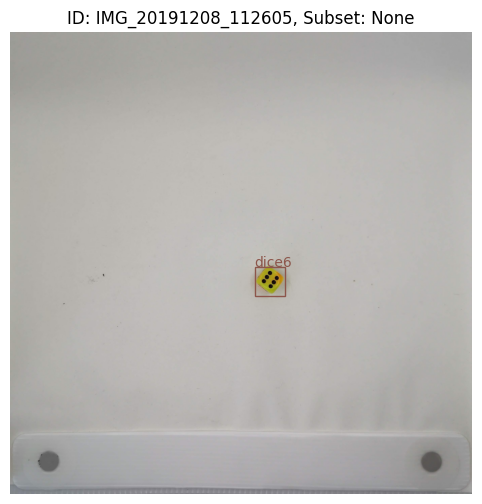

In [8]:
from datumaro import Visualizer

img_id, _ = os.path.splitext(os.path.basename(img_path))
fig = Visualizer(dataset).vis_one_sample(img_id)
fig.show()

# Re-export again to any dataset format with no encryption

Because the encrypted `DatumaroBinary` format cannot easily used for you usage. In this time, we re-export it to any dataset format for the future usage. For example, COCO format is used for the export.

In [9]:
dataset.export("d6-dice-coco", format="coco", save_media=True)

Because our re-export dataset has no encryption, you can read the image files without any problem now!

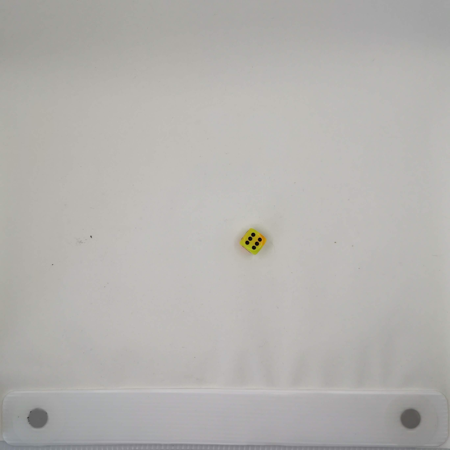

In [10]:
img_root = os.path.join("d6-dice-coco", "images", "default")

for img_name in os.listdir(img_root):
    img_path = os.path.join(img_root, img_name)
    break

Image.open(img_path).resize(size=(450, 450,))